In [1]:
"""
Data from: https://lhncbc.nlm.nih.gov/LHC-publications/pubs/MalariaDatasets.html
"""

'\nData from: https://lhncbc.nlm.nih.gov/LHC-publications/pubs/MalariaDatasets.html\n'

In [2]:
##########################################################
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import vgg16
from tensorflow.keras.optimizers import Adam, SGD
import scipy  #Used to upsample our image

import os
import cv2
from PIL import Image
import numpy as np


In [3]:
# prepare data

image_dir = 'D:\Programming\Python\Data\cell_images'
dataset = []
label = []

parasitised_img = os.listdir(image_dir + '\Parasitized')
for i, image_name in enumerate(parasitised_img):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_dir + '\Parasitized/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((128,128))
        dataset.append(np.array(image))
        label.append(1)

uninfected_img = os.listdir(image_dir + '\PNoninfected')
for i, image_name in enumerate(uninfected_img):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_dir + '\PNoninfected/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((128,128))
        dataset.append(np.array(image))
        label.append(0)
    
dataset = np.array(dataset)
label = np.array(label)


In [4]:
# Split into train and test data sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset, label, test_size = 0.20, random_state = 0)

X_train = X_train /255.
X_test = X_test /255.

from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


In [10]:
# Define a model

def get_model(input_shape = (224,224,3)):
    
    vgg = vgg16.VGG16(weights='imagenet', include_top=False, input_shape = input_shape)

    #for layer in vgg.layers[:-8]:  #Set block4 and block5 to be trainable. 
    for layer in vgg.layers[:-5]:    #Set block5 trainable, all others as non-trainable
        print(layer.name)
        layer.trainable = False #All others as non-trainable.

    x = vgg.output
    x = GlobalAveragePooling2D()(x) # GlobalAveragePooling and "NOT flatten". 
    x = Dense(2, activation="softmax")(x)  # Multiclass problem. 

    model = Model(vgg.input, x)
    model.compile(loss = "categorical_crossentropy", 
                  optimizer = Adam(lr=0.0001), metrics=["accuracy"])
    
    return model


model = get_model(input_shape = (128,128,3))
print(model.summary())


input_4
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Co

In [11]:
history = model.fit(X_train, y_train, batch_size=16, epochs=5, verbose = 1, 
                    validation_data=(X_test,y_test))


Epoch 1/5
1378/1378 [==============================] - 2138s 2s/step - loss: 0.1739 - accuracy: 0.9390 - val_loss: 0.1349 - val_accuracy: 0.9534
Epoch 2/5
1378/1378 [==============================] - 2168s 2s/step - loss: 0.1203 - accuracy: 0.9583 - val_loss: 0.1382 - val_accuracy: 0.9561
Epoch 3/5
1378/1378 [==============================] - 2294s 2s/step - loss: 0.1024 - accuracy: 0.9652 - val_loss: 0.1063 - val_accuracy: 0.9628
Epoch 4/5
1378/1378 [==============================] - 2419s 2s/step - loss: 0.0874 - accuracy: 0.9696 - val_loss: 0.1353 - val_accuracy: 0.9619
Epoch 5/5
1378/1378 [==============================] - 2451s 2s/step - loss: 0.0747 - accuracy: 0.9746 - val_loss: 0.1354 - val_accuracy: 0.9581


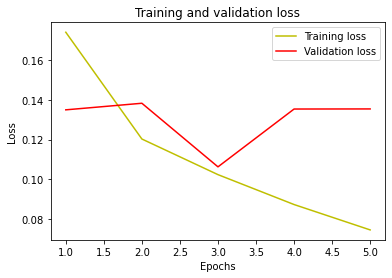

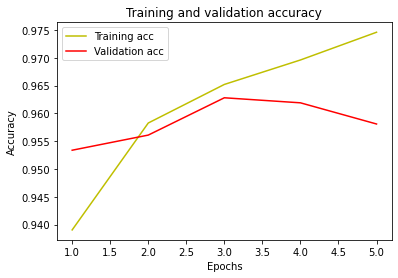

In [12]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [13]:
#Check model accuracy on the test data
_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")


173/173 [==============================] - 429s 2s/step - loss: 0.1354 - accuracy: 0.9581
Accuracy =  95.80914378166199 %


1/1 [==============================] - 0s 368ms/step
The prediction for this image is:  1
The actual label for this image is:  1
173/173 [==============================] - 416s 2s/step


<AxesSubplot:>

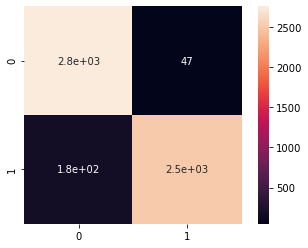

In [15]:
#Test on single image.
n=10  #Select the index of image to be loaded for testing
img = X_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
print("The prediction for this image is: ", np.argmax(model.predict(input_img)))
print("The actual label for this image is: ", np.argmax(y_test[n]))

#Print confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = np.argmax(model.predict(X_test), axis=1)
cm=confusion_matrix(np.argmax(y_test, axis=1), y_pred)  
sns.heatmap(cm, annot=True)


In [16]:
#Identify all images classified as parasitized
parasited_image_idx = np.where(y_pred == 1)[0]

#Save all images classified as parasited to a directory (optional, makes sense for large data sets)
#capture it in memory as an array
predicted_as_para=[]
for i in parasited_image_idx:
    par_img = X_test[i]
    #plt.imsave("results_classified_as_para/para_"+str(i)+".png", par_img)
    predicted_as_para.append(par_img)
    
predicted_as_para = np.array(predicted_as_para)    


In [36]:
from matplotlib.patches import Rectangle #To add a rectangle overlay to the image
from skimage.feature.peak import peak_local_max  #To detect hotspots in 2D images. 

def plot_heatmap(img):
  
    pred = model.predict(np.expand_dims(img, axis=0))
    pred_class = np.argmax(pred)
    #Get weights for all classes from the prediction layer
    last_layer_weights = model.layers[-1].get_weights()[0] #Prediction layer
    #Get weights for the predicted class.
    last_layer_weights_for_pred = last_layer_weights[:, pred_class]
    #Get output from the last conv. layer
    last_conv_model = Model(model.input, model.get_layer("block5_conv3").output)
    last_conv_output = last_conv_model.predict(img[np.newaxis,:,:,:])
    last_conv_output = np.squeeze(last_conv_output)
    
    #Upsample/resize the last conv. output to same size as original image
    h = int(img.shape[0]/last_conv_output.shape[0])
    w = int(img.shape[1]/last_conv_output.shape[1])
    upsampled_last_conv_output = scipy.ndimage.zoom(last_conv_output, (h, w, 1), order=1)
    
    heat_map = np.dot(upsampled_last_conv_output.reshape((img.shape[0]*img.shape[1], 512)), 
                 last_layer_weights_for_pred).reshape(img.shape[0],img.shape[1])
    
    #Since we have a lot of dark pixels where the edges may be thought of as 
    #high anomaly, let us drop all heat map values in this region to 0.
    #This is an optional step based on the image. 
    heat_map[img[:,:,0] == 0] = 0  #All dark pixels outside the object set to 0
    
    #Detect peaks (hot spots) in the heat map. We will set it to detect maximum 5 peaks.
    #with rel threshold of 0.5 (compared to the max peak). 
    peak_coords = peak_local_max(heat_map, num_peaks=5, threshold_rel=0.3, min_distance=10) 
    
    plt.figure()
    plt.imshow(heat_map, cmap='jet', alpha=0.5)
    
    plt.figure()
    plt.imshow(img.astype('float32').reshape(img.shape[0],img.shape[1],3))
    plt.imshow(heat_map, cmap='jet', alpha=0.5)
    for i in range(0,peak_coords.shape[0]):
        print(i)
        y = peak_coords[i,0]
        x = peak_coords[i,1]
        plt.gca().add_patch(Rectangle((x-25, y-25), 35,35,linewidth=1,edgecolor='r',facecolor='none'))
        
        print(x," and ", y)

1/1 [==============================] - 0s 273ms/step
0
36  and  36


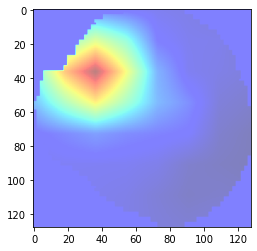

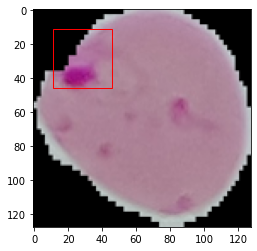

In [37]:
import random 
im = random.randint(0,predicted_as_para.shape[0]-1)
heat_map =plot_heatmap(predicted_as_para[im])

img = predicted_as_para[im]
plt.imshow(predicted_as_para[im])
